In [1]:
import json
import os
import re
from glob import glob
import numpy as np
import geopandas as gpd
from rasterio.mask import mask
from rasterio.plot import show
import fnmatch
import rasterio as rio
import rasterstats as rs
import matplotlib.pyplot as plt
from analyses.munging import reproject_raster
import analyses.munging as munge
from pprint import pp
from datetime import date
from zipfile import ZipFile
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from shapely.geometry import MultiPolygon, Polygon

In [39]:
folder_name = 'strips'
# folder_name = 'biocentury'
# folder_name = 'cas'
# field_name = 'basswood'
# field_name = 'interim'
field_name = 'orbweavernorth'
# field_name = 'orbweaversouth'
# field_name = 'ebilsland'
# field_name = 'cas'
start_date = '20160701'
end_date = '20160731'
wd = 'C:\\Users\\mjn\\Documents\\Dev\\Foresite\\geospatial'
os.chdir(wd)
# field_boundary_file = 'accola_bounds_4326.geojson'
# field_boundary_file = 'eb_kf_bounds_4326.geojson'
# field_boundary_file = 'basswood_bounds_4326.geojson'
# field_boundary_file = 'interim_bounds_4326.geojson'
field_boundary_file = 'orbweaver_north_bounds_4326.geojson'
# field_boundary_file = 'orbweaver_south_bounds_4326.geojson'
# field_boundary_file = 'cas_bounds.geojson'
footprint = geojson_to_wkt(read_geojson(f'data\\field_boundaries\\{field_boundary_file}'))
img_downloads_path = f'data\\img_downloads\\{folder_name}'
ndvi_out_path = f'data\\ndvi\\{folder_name}\\{field_name}'
field_bounds = gpd.read_file(f'data\\field_boundaries\\{field_boundary_file}')
field_32615 = field_bounds.to_crs({'init': 'epsg:32615'})

C:\Users\mjn\miniconda3\envs\gis\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [27]:
api = SentinelAPI('mnowatzke', 'Lux68bourg19&', 'https://scihub.copernicus.eu/dhus')

In [28]:
products_gdf = munge.find_sentinel_products(footprint, api, start_date, end_date, 60)
products_gdf_sorted = products_gdf.sort_values(['cloudcoverpercentage'], ascending=[True])
products_gdf_sorted['cloudcoverpercentage']

68c1f3e6-17d5-4a64-bb2a-daa769c94b19     0.0000
bafca01a-79bc-46d9-87f2-c077bd3cdba6    13.1387
Name: cloudcoverpercentage, dtype: float64

In [29]:
img_index = 0

In [30]:
img_uuid = products_gdf_sorted.index[img_index]
img_meta = products_gdf_sorted.iloc[img_index]
img_title = img_meta['title']
img_title

'S2A_MSIL1C_20160711T170312_N0204_R069_T15TVF_20160711T171110'

In [9]:
image_download = munge.download_sentinel_image(products_gdf_sorted, api, img_downloads_path, img_index=img_index)

In [40]:
large_ndvi_out_path = f"{ndvi_out_path}\\{img_title}_ndvi.tiff"
cropped_out_path = f"{ndvi_out_path}\\{img_title}_{field_name}_ndvi.tiff"
large_ndvi_out_path, cropped_out_path

('data\\ndvi\\strips\\orbweavernorth\\S2A_MSIL1C_20160711T170312_N0204_R069_T15TVF_20160711T171110_ndvi.tiff',
 'data\\ndvi\\strips\\orbweavernorth\\S2A_MSIL1C_20160711T170312_N0204_R069_T15TVF_20160711T171110_orbweavernorth_ndvi.tiff')

In [18]:
#munge.check_product_status(img_uuid, api)

In [ ]:
os.chdir(wd)

In [ ]:
munge.unzip_sentinel_images(img_downloads_path, img_title)

In [41]:
img_path = f"{img_downloads_path}\\{img_title}.SAFE\\GRANULE\\"
#img_path = "data/S2A_MSIL1C_20180724T170851_N0206_R112_T15TVG_20180724T220929.SAFE/GRANULE/L1C_T15TVG_A016125_20180724T171717/IMG_DATA"

In [42]:
img_path

'data\\img_downloads\\strips\\S2A_MSIL1C_20160711T170312_N0204_R069_T15TVF_20160711T171110.SAFE\\GRANULE\\'

In [43]:
file_list = munge.locate_NIR_RED_images(img_path)
if len(file_list) == 0:
    print('No images found.')
else:
    pp(file_list)

['data\\img_downloads\\strips\\S2A_MSIL1C_20160711T170312_N0204_R069_T15TVF_20160711T171110.SAFE\\GRANULE\\L1C_T15TVF_A005500_20160711T171110\\IMG_DATA\\T15TVF_20160711T170312_B04.jp2',
 'data\\img_downloads\\strips\\S2A_MSIL1C_20160711T170312_N0204_R069_T15TVF_20160711T171110.SAFE\\GRANULE\\L1C_T15TVF_A005500_20160711T171110\\IMG_DATA\\T15TVF_20160711T170312_B08.jp2']


In [44]:
munge.create_ndvi_tif(file_list, large_ndvi_out_path)

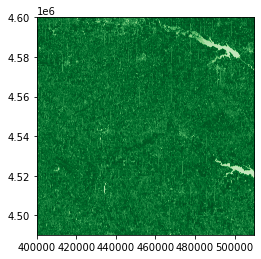

In [45]:
ndvi_all = rio.open(large_ndvi_out_path)
show((ndvi_all, 1), cmap="Greens")

In [46]:
munge.clip_raster(large_ndvi_out_path, field_32615.geometry, cropped_out_path)

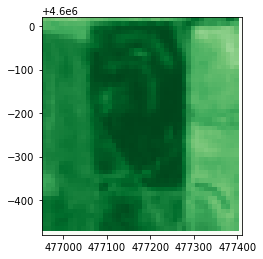

In [47]:
ndvi_clipped = rio.open(cropped_out_path)
show((ndvi_clipped, 1), cmap="Greens")